In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv("Disaster.csv")
data.columns

Index(['Name', 'UserName', 'Timestamp', 'Verified', 'Tweets', 'Comments',
       'Retweets', 'Likes', 'Impressions', 'Tags', 'Tweet Link', 'Tweet ID',
       'Disaster'],
      dtype='object')

In [2]:
data.shape

(2559, 13)

In [3]:
data.describe()

,Comments,Retweets,Impressions,Tweet ID
count,2559.000000,2559.000000,2559.000000,2.559000e+03
mean,0.775694,3.789371,1195.523251,1.763440e+18
std,7.866340,21.404218,6360.882788,9.546477e+14
min,0.000000,0.000000,0.000000,1.761070e+18
25%,0.000000,0.000000,55.000000,1.762720e+18
50%,0.000000,0.000000,170.000000,1.763550e+18
75%,0.000000,2.000000,568.000000,1.764400e+18
max,369.000000,701.000000,159000.000000,1.764620e+18


In [4]:
data.isna().sum()

Name           1
UserName       0
Timestamp      0
Verified       0
Tweets         0
Comments       0
Retweets       0
Likes          0
Impressions    0
Tags           0
Tweet Link     0
Tweet ID       0
Disaster       0
dtype: int64

In [5]:
data.Comments.value_counts()

Comments
0      1977
1       363
2        78
3        37
4        36
5        15
6         9
7         5
8         5
11        4
10        4
9         4
23        4
20        3
13        2
12        2
22        2
31        1
17        1
14        1
369       1
15        1
34        1
28        1
100       1
33        1
Name: count, dtype: int64

In [6]:
data.Verified.value_counts()

Verified
False    1912
True      647
Name: count, dtype: int64

In [7]:
data.Impressions.describe()

count      2559.000000
mean       1195.523251
std        6360.882788
min           0.000000
25%          55.000000
50%         170.000000
75%         568.000000
max      159000.000000
Name: Impressions, dtype: float64

In [8]:
data.Disaster.head()

0       Drought
1       Drought
2        Floods
3      Wildfire
4    Hurricanes
Name: Disaster, dtype: object

In [9]:
data.Disaster.nunique()

6

In [10]:
data.Disaster.value_counts().sort_index()

Disaster
Drought       770
Earthquake    500
Floods        436
Hurricanes    178
Tornadoes     135
Wildfire      540
Name: count, dtype: int64

In [11]:
data.Disaster.value_counts().sort_index()

Disaster
Drought       770
Earthquake    500
Floods        436
Hurricanes    178
Tornadoes     135
Wildfire      540
Name: count, dtype: int64

NameError: name 'disaster_mapping' is not defined

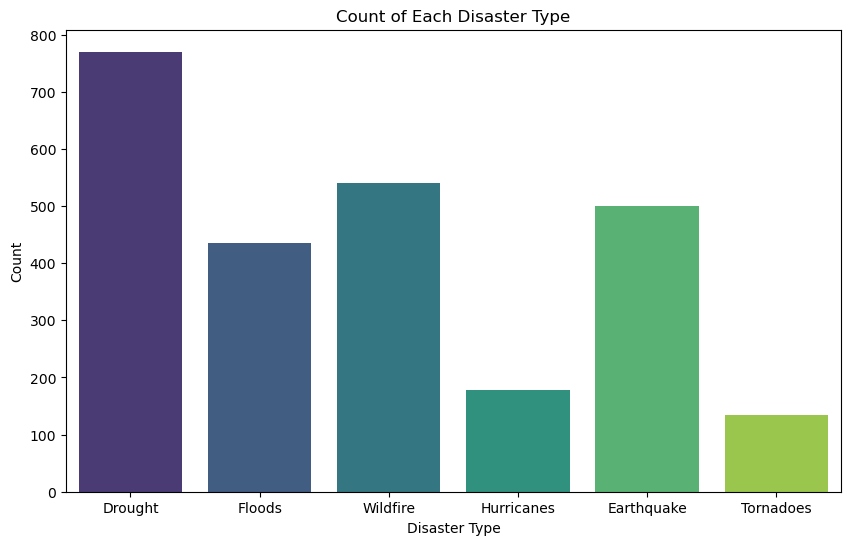

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Disaster', data=data, palette='viridis')
plt.title('Count of Each Disaster Type')
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.xticks(ticks=range(len(disaster_mapping)), labels=disaster_mapping.keys())
plt.show()

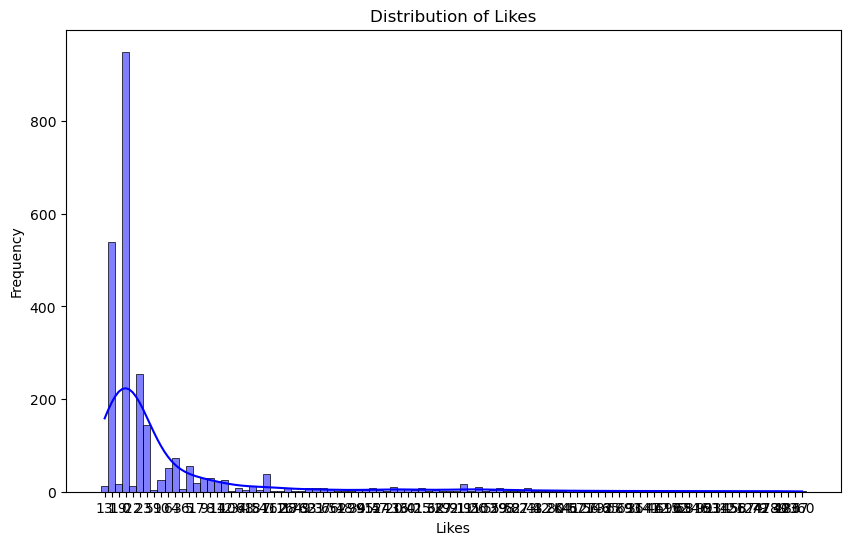

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Likes'], bins=30, kde=True, color='blue')
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.show()

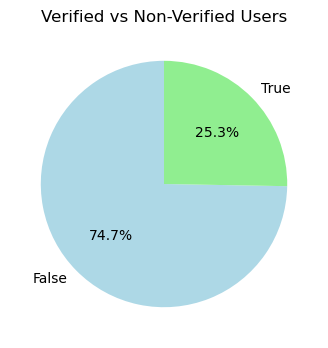

In [ ]:
plt.figure(figsize=(4, 4))
data['Verified'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Verified vs Non-Verified Users')
plt.ylabel('')
plt.show()

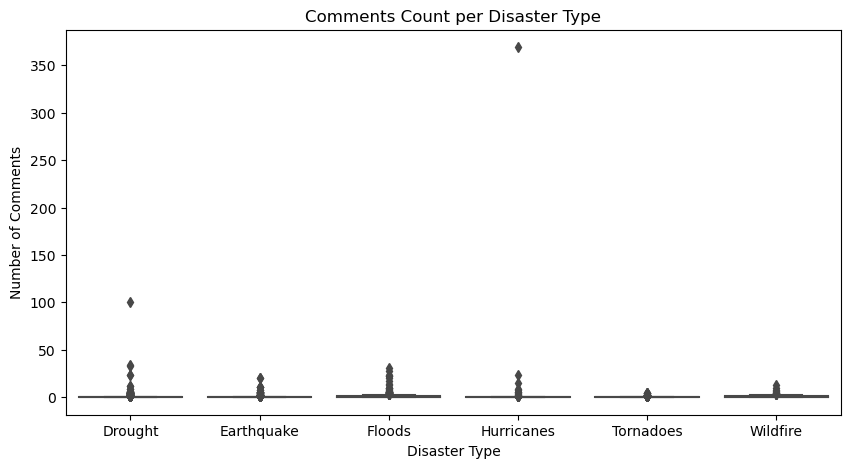

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Disaster', y='Comments', data=data, palette='Set1')
plt.title('Comments Count per Disaster Type')
plt.xlabel('Disaster Type')
plt.ylabel('Number of Comments')
plt.xticks(ticks=range(len(disaster_mapping)), labels=disaster_mapping.keys())
plt.show()

In [13]:
# Create a mapping dictionary for disaster types
disaster_mapping = {
    'Drought': 0,
    'Earthquake': 1,
    'Floods': 2,
    'Hurricanes': 3,
    'Tornadoes': 4,
    'Wildfire': 5
}

# Apply the mapping to the Disaster column
data['Disaster'] = data['Disaster'].map(disaster_mapping)

In [14]:
texts = data["Tweets"].tolist()
labels = data["Disaster"].tolist()